In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/segmentation-full-body-tiktok-dancing-dataset.zip" "/content"

In [ ]:
!unzip *.zip && rm -rf *.zip

#DataGenerator

In [100]:
import tensorflow as tf
import os
import numpy as np

In [102]:
class VizDataGen(tf.keras.utils.Sequence):
    def __init__(self, paths, IMAGES_PATH, MASKS_PATH,
                 batch_size,
                 input_size=(256, 256, 3)):
        self.df = paths.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.IMAGES_PATH = IMAGES_PATH
        self.MASKS_PATH = MASKS_PATH
        
        self.n = len(self.df)
        self.m = 0
        self.max = self.__len__()
    
    def __len__(self):
        return int(len(self.df) / float(self.batch_size))
    
    def __get_image(self, path, target_size):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        image_arr = image_arr / 255.
        image_arr = image_arr.astype(np.float32)
        return image_arr

    def __get_mask(self, path, target_size):
        image = tf.keras.preprocessing.image.load_img(path, color_mode = "grayscale")
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        image_arr = image_arr / 255.
        image_arr = image_arr.astype(np.float32)
        return image_arr
    
    def __get_X(self, batches):
        # Generates data containing batch_size samples
        batch = np.asarray([self.__get_image(x, self.input_size) for x in batches])
        return batch

    def __get_Y(self, batches):
        # Generates data containing batch_size samples
        batch = np.asarray([self.__get_mask(x, self.input_size) for x in batches])
        return batch

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X_batches = [os.path.join(self.IMAGES_PATH, img) for img in batches]
        Y_batches = [os.path.join(self.MASKS_PATH, img) for img in batches]
        X = self.__get_X(X_batches)
        Y = self.__get_Y(Y_batches)
        return X, Y
    
    def __next__(self):
        if self.m >= self.max:
            self.m = 0
        X, Y = self.__getitem__(self.m)
        self.m += 1
        return X, Y

In [40]:
!pip install split-folders

import splitfolders
splitfolders.ratio('/content/segmentation_full_body_tik_tok_2615_img', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

Copying files: 7845 files [00:08, 908.34 files/s] 


In [41]:
!rm -rf "/content/segmentation_full_body_tik_tok_2615_img"

In [103]:
TRAIN_IMAGES_PATH = "/content/output/train/images"
TRAIN_MASKS_PATH = "/content/output/train/masks"
train_images = os.listdir(TRAIN_IMAGES_PATH)

train_generator = VizDataGen(
    paths=train_images, 
    IMAGES_PATH=TRAIN_IMAGES_PATH, 
    MASKS_PATH=TRAIN_MASKS_PATH, 
    batch_size=10
)

In [104]:
TEST_IMAGES_PATH = "/content/output/test/images"
TEST_MASKS_PATH = "/content/output/test/masks"
test_images = os.listdir(TEST_IMAGES_PATH)

test_generator = VizDataGen(
    paths=test_images, 
    IMAGES_PATH=TEST_IMAGES_PATH, 
    MASKS_PATH=TEST_MASKS_PATH, 
    batch_size=10
)

In [105]:
VAL_IMAGES_PATH = "/content/output/val/images"
VAL_MASKS_PATH = "/content/output/val/masks"
val_images = os.listdir(VAL_IMAGES_PATH)

val_generator = VizDataGen(
    paths=val_images, 
    IMAGES_PATH=VAL_IMAGES_PATH, 
    MASKS_PATH=VAL_MASKS_PATH, 
    batch_size=10
)

In [106]:
train_generator.__len__()

116

In [107]:
test_generator.__len__()

14

In [108]:
val_generator.__len__()

14

In [109]:
x, y = next(train_generator)

#Displaying

In [110]:
import matplotlib.pyplot as plt

def show(ground, mask):
  plt.subplot(1, 2, 1)
  plt.title("Ground Image")
  plt.imshow(ground)
  plt.subplot(1, 2, 2)
  plt.title("Mask")
  plt.imshow(mask.reshape(256, 256), cmap="binary")
  plt.show()

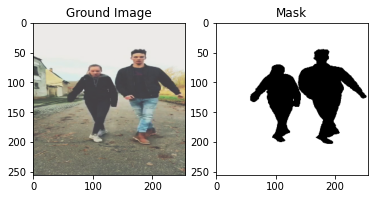

In [111]:
show(x[3], y[3])

#Model

In [112]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [114]:
# Contraction or Encoder Part

input = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# Converting Integers to Floats
s = tf.keras.layers.Lambda(lambda x : x / 255.)(input)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(s)
c1 = tf.keras.layers.Dropout(rate=0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c1)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(rate=0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(rate=0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(rate=0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(rate=0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c5)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)

c6 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Dropout(rate=0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c6)

ca = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(c6)
ca = tf.keras.layers.Dropout(rate=0.2)(ca)
ca = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(ca)

# Expansion or Decoder Part
u6 = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(ca)
print("C5: ", c5.shape)
print("U6: ", u6.shape)
u6 = tf.keras.layers.add([u6, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(u6)
c7 = tf.keras.layers.Dropout(rate=0.1)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c7)

u7 = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(c7)
print("C4: ", c4.shape)
print("U7: ", u7.shape)
u7 = tf.keras.layers.add([u7, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(u7)
c8 = tf.keras.layers.Dropout(rate=0.1)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c8)

u8 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(c8)
print("C3: ", c3.shape)
print("U8: ", u8.shape)
u8 = tf.keras.layers.add([u8, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(u8)
c9 = tf.keras.layers.Dropout(rate=0.1)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c9)

u9 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(c9)
print("C9: ", c2.shape)
print("U9: ", u9.shape)
u9 = tf.keras.layers.add([u9, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(u9)
c10 = tf.keras.layers.Dropout(rate=0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c10)

u10 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same")(c10)
print("C1: ", c1.shape)
print("U10: ", u10.shape)
u10 = tf.keras.layers.add([u10, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(u10)
c11 = tf.keras.layers.Dropout(rate=0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same")(c11)

output = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(c11)
model = tf.keras.models.Model(inputs = [input], outputs = [output])

C5:  (None, 16, 16, 256)
U6:  (None, 16, 16, 256)
C4:  (None, 32, 32, 128)
U7:  (None, 32, 32, 128)
C3:  (None, 64, 64, 64)
U8:  (None, 64, 64, 64)
C9:  (None, 128, 128, 32)
U9:  (None, 128, 128, 32)
C1:  (None, 256, 256, 16)
U10:  (None, 256, 256, 16)


In [115]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_15 (Lambda)             (None, 256, 256, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv2d_325 (Conv2D)            (None, 256, 256, 16  448         ['lambda_15[0][0]']              
                                )                                                                 
                                                                                            

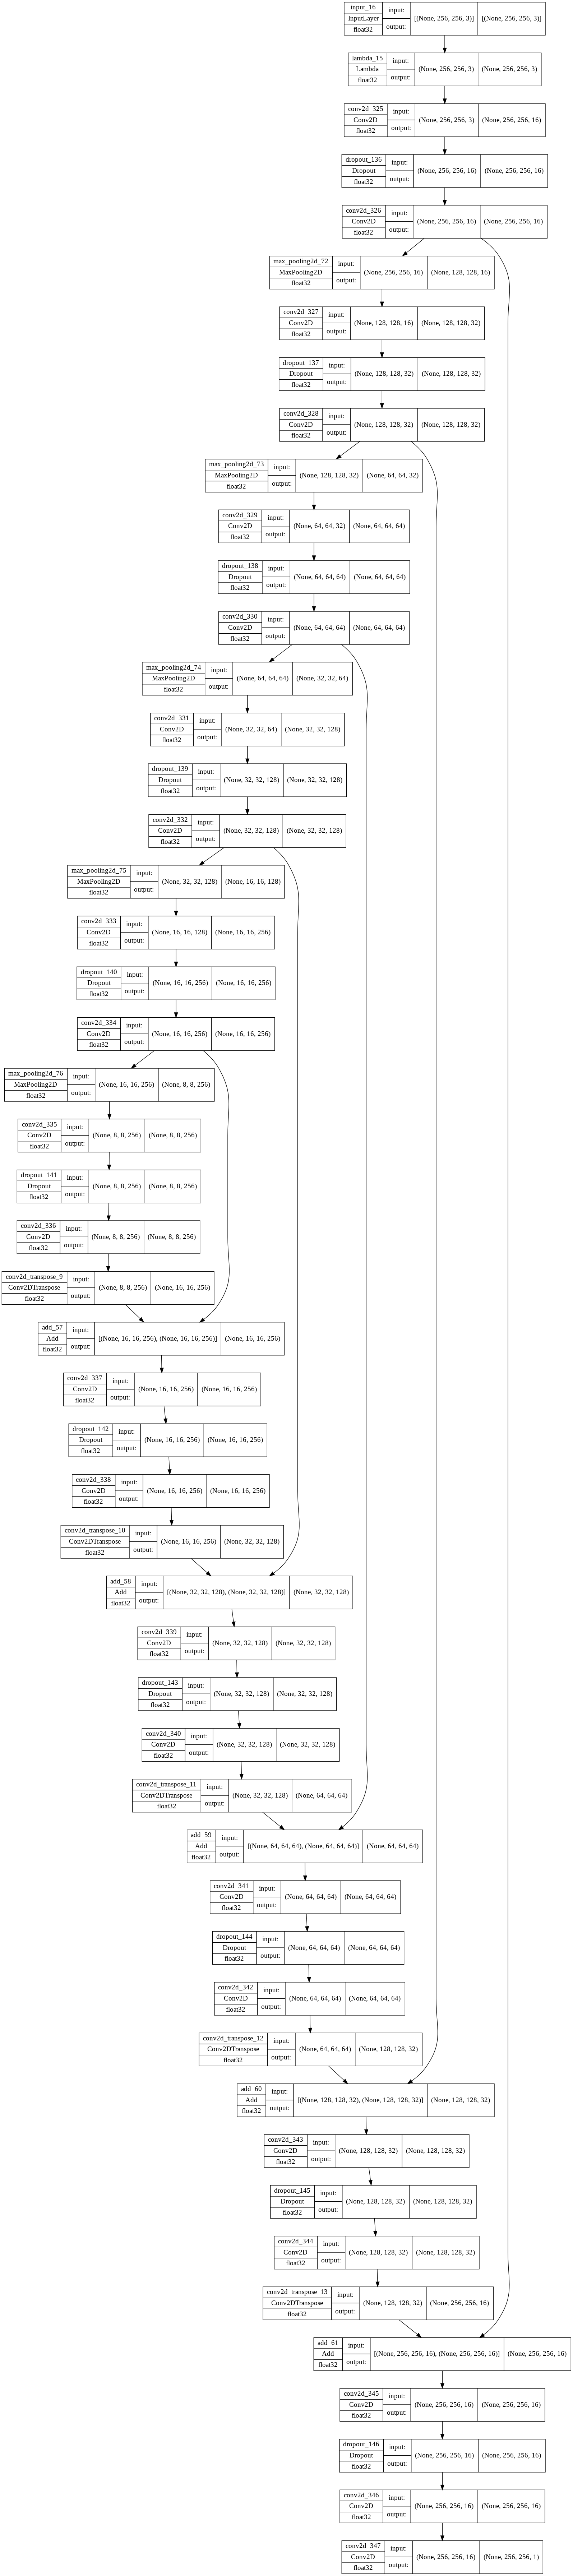

In [116]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True)

#Callbacks

In [118]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5",
                                              monitor="val_loss",
                                              mode="min",
                                              save_best_only=True,
                                              verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 min_delta=0,
                                                 patience=3,
                                                 verbose=1,
                                                 restore_best_weights=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs")
callbacks = [earlystopping, checkpoint, tensorboard]

In [119]:
def iou(y_true,y_pred):
  def f(y_true,y_pred):
    intersection = (y_true*y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f,[y_true,y_pred],tf.float32)

In [120]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy", iou])

In [121]:
model_history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8929 - iou: 0.1112
Epoch 1: val_loss improved from inf to 0.24705, saving model to model.h5
116/116 [==============================] - 127s 1s/step - loss: 0.3463 - accuracy: 0.8929 - iou: 0.1112 - val_loss: 0.2471 - val_accuracy: 0.9009 - val_iou: 0.1451
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9008 - iou: 0.1517
Epoch 2: val_loss improved from 0.24705 to 0.24366, saving model to model.h5
116/116 [==============================] - 122s 1s/step - loss: 0.2400 - accuracy: 0.9008 - iou: 0.1517 - val_loss: 0.2437 - val_accuracy: 0.9009 - val_iou: 0.1472
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9008 - iou: 0.1534
Epoch 3: val_loss improved from 0.24366 to 0.23315, saving model to model.h5
116/116 [==============================] - 121s 1s/step - loss: 0.2411 - accuracy: 0.9008 - iou: 0.1534 - val_lo

When Use UpSampling Layers

In [77]:
x, y = next(val_generator)

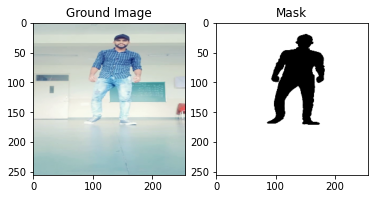

In [82]:
show(x[3], y[3])

In [83]:
pred = model.predict(tf.expand_dims(x[3], 0))

Text(0.5, 1.0, 'Predicted')

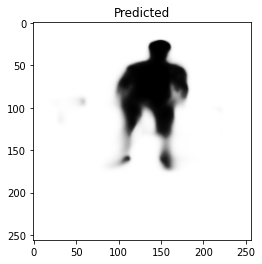

In [84]:
import matplotlib.pyplot as plt

plt.imshow(pred.reshape((256, 256)), cmap="binary")
plt.title("Predicted")

When using Conv2DTranspose layers

In [122]:
x, y = next(val_generator)

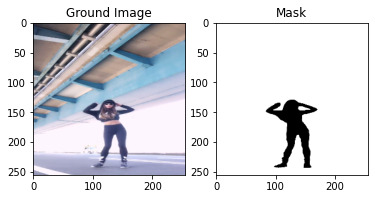

In [123]:
show(x[8], y[8])

In [124]:
pred = model.predict(tf.expand_dims(x[8], 0))

Text(0.5, 1.0, 'Predicted')

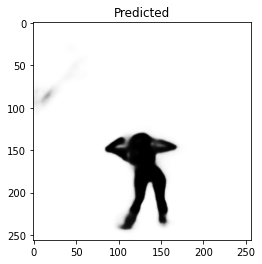

In [125]:
import matplotlib.pyplot as plt

plt.imshow(pred.reshape((256, 256)), cmap="binary")
plt.title("Predicted")